## 1. Setup & Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time
import warnings

# Scikit-learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# MLflow
import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Paths
PROCESSED_DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete!")


✅ Setup complete!


In [2]:
# Install additional packages if needed
!pip install xgboost lightgbm


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 5.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# Try importing XGBoost and LightGBM
try:
    import xgboost as xgb
    print(f"✅ XGBoost version: {xgb.__version__}")
    HAS_XGB = True
except ImportError:
    print("⚠️ XGBoost not installed. Run: pip install xgboost")
    HAS_XGB = False

try:
    import lightgbm as lgb
    print(f"✅ LightGBM version: {lgb.__version__}")
    HAS_LGB = True
except ImportError:
    print("⚠️ LightGBM not installed. Run: pip install lightgbm")
    HAS_LGB = False


✅ XGBoost version: 3.0.0
✅ LightGBM version: 4.6.0


## 2. Load Processed Data

In [4]:
# Load train, validation, test data
train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train.parquet')
val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val.parquet')
test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test.parquet')

print("📊 Data Loaded:")
print(f"   Train: {train_df.shape}")
print(f"   Validation: {val_df.shape}")
print(f"   Test: {test_df.shape}")


📊 Data Loaded:
   Train: (11168247, 19)
   Validation: (2393196, 19)
   Test: (2393196, 19)


In [5]:
# Load feature configuration
feature_config = joblib.load(PROCESSED_DATA_DIR / 'feature_config.joblib')

NUMERICAL_FEATURES = feature_config['numerical_features']
CATEGORICAL_FEATURES = feature_config['categorical_features']
BINARY_FEATURES = feature_config['binary_features']
ALL_FEATURES = feature_config['all_features']
TARGET = feature_config['target']

print(f"📋 Features: {len(ALL_FEATURES)}")
print(f"   Target: {TARGET}")


📋 Features: 18
   Target: fare_amount


In [6]:
# Prepare X and y
X_train = train_df[ALL_FEATURES]
y_train = train_df[TARGET]

X_val = val_df[ALL_FEATURES]
y_val = val_df[TARGET]

X_test = test_df[ALL_FEATURES]
y_test = test_df[TARGET]

print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"   X_test: {X_test.shape}, y_test: {y_test.shape}")


✅ X_train: (11168247, 18), y_train: (11168247,)
   X_val: (2393196, 18), y_val: (2393196,)
   X_test: (2393196, 18), y_test: (2393196,)


In [23]:
X_train.columns


Index(['trip_distance', 'passenger_count', 'trip_duration_minutes',
       'avg_speed_mph', 'pickup_hour', 'pickup_dayofweek', 'pickup_month',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'PULocationID',
       'DOLocationID', 'VendorID', 'is_weekend', 'is_rush_hour',
       'same_location', 'has_tolls'],
      dtype='object')

In [7]:
# Untuk development/testing yang lebih cepat, kita bisa sampling
# Uncomment jika ingin sample data

SAMPLE_SIZE = 100000  # Set ke angka (misal 100000) untuk sampling

if SAMPLE_SIZE:
    print(f"⚠️ Sampling data to {SAMPLE_SIZE:,} rows for faster training...")
    X_train = X_train.sample(n=min(SAMPLE_SIZE, len(X_train)), random_state=42)
    y_train = y_train.loc[X_train.index]
    
    X_val = X_val.sample(n=min(SAMPLE_SIZE//4, len(X_val)), random_state=42)
    y_val = y_val.loc[X_val.index]
    
    print(f"   X_train: {X_train.shape}")
    print(f"   X_val: {X_val.shape}")


⚠️ Sampling data to 100,000 rows for faster training...
   X_train: (100000, 18)
   X_val: (25000, 18)


## 3. Setup MLflow

In [8]:
# Setup MLflow
MLFLOW_TRACKING_URI = "../mlruns"  # Local tracking
EXPERIMENT_NAME = "nyc-taxi-fare-prediction"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"✅ MLflow setup complete!")
print(f"   Tracking URI: {MLFLOW_TRACKING_URI}")
print(f"   Experiment: {EXPERIMENT_NAME}")


2025/12/12 23:52:20 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-fare-prediction' does not exist. Creating a new experiment.


✅ MLflow setup complete!
   Tracking URI: ../mlruns
   Experiment: nyc-taxi-fare-prediction


## 4. Define Evaluation Metrics

In [9]:
def evaluate_model(y_true, y_pred):
    """
    Calculate regression metrics.
    """
    metrics = {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'r2': r2_score(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred) * 100
    }
    return metrics

def print_metrics(metrics, prefix=""):
    """
    Print metrics nicely.
    """
    print(f"{prefix}MAE:  ${metrics['mae']:.4f}")
    print(f"{prefix}RMSE: ${metrics['rmse']:.4f}")
    print(f"{prefix}R²:   {metrics['r2']:.4f}")
    print(f"{prefix}MAPE: {metrics['mape']:.2f}%")


## 5. Define Models

In [10]:
# Define models to train
MODELS = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'ridge': {
        'model': Ridge(alpha=1.0),
        'params': {'alpha': 1.0}
    },
    'lasso': {
        'model': Lasso(alpha=0.1),
        'params': {'alpha': 0.1}
    },
    'random_forest': {
        'model': RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ),
        'params': {
            'n_estimators': 100,
            'max_depth': 15,
            'min_samples_split': 10,
            'min_samples_leaf': 5
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        ),
        'params': {
            'n_estimators': 100,
            'max_depth': 5,
            'learning_rate': 0.1,
            'min_samples_split': 10,
            'min_samples_leaf': 5
        }
    }
}

# Add XGBoost if available
if HAS_XGB:
    MODELS['xgboost'] = {
        'model': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ),
        'params': {
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
    }

# Add LightGBM if available
if HAS_LGB:
    MODELS['lightgbm'] = {
        'model': lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        'params': {
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
    }

print(f"📊 Models to train: {len(MODELS)}")
for name in MODELS.keys():
    print(f"   - {name}")


📊 Models to train: 7
   - linear_regression
   - ridge
   - lasso
   - random_forest
   - gradient_boosting
   - xgboost
   - lightgbm


## 6. Train Models with MLflow Tracking

In [11]:
def train_and_log_model(model_name, model_config, X_train, y_train, X_val, y_val):
    """
    Train a model and log to MLflow.
    """
    print(f"\n{'='*60}")
    print(f"🚀 Training: {model_name}")
    print(f"{'='*60}")
    
    model = model_config['model']
    params = model_config['params']
    
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)
        mlflow.log_param('model_type', model_name)
        mlflow.log_param('n_features', X_train.shape[1])
        mlflow.log_param('n_train_samples', X_train.shape[0])
        
        # Train
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        print(f"   Training time: {train_time:.2f}s")
        mlflow.log_metric('training_time_seconds', train_time)
        
        # Predict on train
        y_train_pred = model.predict(X_train)
        train_metrics = evaluate_model(y_train, y_train_pred)
        
        # Predict on validation
        y_val_pred = model.predict(X_val)
        val_metrics = evaluate_model(y_val, y_val_pred)
        
        # Log metrics
        for metric_name, value in train_metrics.items():
            mlflow.log_metric(f'train_{metric_name}', value)
        
        for metric_name, value in val_metrics.items():
            mlflow.log_metric(f'val_{metric_name}', value)
        
        # Print metrics
        print(f"\n   📊 Train Metrics:")
        print_metrics(train_metrics, prefix="      ")
        print(f"\n   📊 Validation Metrics:")
        print_metrics(val_metrics, prefix="      ")
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        # Get run ID
        run_id = mlflow.active_run().info.run_id
        print(f"\n   ✅ Logged to MLflow (run_id: {run_id[:8]}...)")
        
        return {
            'model_name': model_name,
            'model': model,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'train_time': train_time,
            'run_id': run_id
        }


In [12]:
# Train all models
results = []

for model_name, model_config in MODELS.items():
    result = train_and_log_model(
        model_name, model_config,
        X_train, y_train,
        X_val, y_val
    )
    results.append(result)

print("\n" + "="*60)
print("✅ All models trained!")
print("="*60)



🚀 Training: linear_regression


2025/12/12 23:52:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Training time: 0.06s

   📊 Train Metrics:
      MAE:  $1.9341
      RMSE: $4.9538
      R²:   0.9168
      MAPE: 11.17%

   📊 Validation Metrics:
      MAE:  $1.9911
      RMSE: $5.3091
      R²:   0.9081
      MAPE: 11.25%


2025/12/12 23:52:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



   ✅ Logged to MLflow (run_id: 25d58c21...)

🚀 Training: ridge
   Training time: 0.02s

   📊 Train Metrics:
      MAE:  $1.9341
      RMSE: $4.9538
      R²:   0.9168
      MAPE: 11.17%

   📊 Validation Metrics:
      MAE:  $1.9911
      RMSE: $5.3091
      R²:   0.9081
      MAPE: 11.25%


2025/12/12 23:52:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



   ✅ Logged to MLflow (run_id: 15ee6b7b...)

🚀 Training: lasso
   Training time: 0.04s

   📊 Train Metrics:
      MAE:  $1.9268
      RMSE: $4.9679
      R²:   0.9163
      MAPE: 11.12%

   📊 Validation Metrics:
      MAE:  $1.9905
      RMSE: $5.3287
      R²:   0.9074
      MAPE: 11.28%

   ✅ Logged to MLflow (run_id: 626e3f30...)

🚀 Training: random_forest
   Training time: 5.58s


2025/12/12 23:52:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



   📊 Train Metrics:
      MAE:  $0.8765
      RMSE: $2.9159
      R²:   0.9712
      MAPE: 4.98%

   📊 Validation Metrics:
      MAE:  $1.1288
      RMSE: $3.8475
      R²:   0.9517
      MAPE: 6.17%

   ✅ Logged to MLflow (run_id: bfaa761d...)

🚀 Training: gradient_boosting


2025/12/12 23:53:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Training time: 24.46s

   📊 Train Metrics:
      MAE:  $1.0499
      RMSE: $2.9685
      R²:   0.9701
      MAPE: 5.89%

   📊 Validation Metrics:
      MAE:  $1.1445
      RMSE: $3.8244
      R²:   0.9523
      MAPE: 6.18%

   ✅ Logged to MLflow (run_id: db77b1fe...)

🚀 Training: xgboost


2025/12/12 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Training time: 0.94s

   📊 Train Metrics:
      MAE:  $1.0196
      RMSE: $2.7449
      R²:   0.9745
      MAPE: 5.76%

   📊 Validation Metrics:
      MAE:  $1.1334
      RMSE: $3.6940
      R²:   0.9555
      MAPE: 6.14%

   ✅ Logged to MLflow (run_id: e8f0648b...)

🚀 Training: lightgbm


2025/12/12 23:53:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Training time: 1.01s

   📊 Train Metrics:
      MAE:  $1.0755
      RMSE: $3.1542
      R²:   0.9663
      MAPE: 5.92%

   📊 Validation Metrics:
      MAE:  $1.1425
      RMSE: $3.7636
      R²:   0.9538
      MAPE: 6.17%

   ✅ Logged to MLflow (run_id: 0c5552cd...)

✅ All models trained!


## 7. Compare Model Performance

In [13]:
# Create comparison dataframe
comparison_data = []
for r in results:
    comparison_data.append({
        'Model': r['model_name'],
        'Train MAE': r['train_metrics']['mae'],
        'Val MAE': r['val_metrics']['mae'],
        'Train RMSE': r['train_metrics']['rmse'],
        'Val RMSE': r['val_metrics']['rmse'],
        'Train R²': r['train_metrics']['r2'],
        'Val R²': r['val_metrics']['r2'],
        'Val MAPE (%)': r['val_metrics']['mape'],
        'Train Time (s)': r['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Val MAE').reset_index(drop=True)

print("📊 Model Comparison (sorted by Validation MAE):")
print("="*100)
comparison_df


📊 Model Comparison (sorted by Validation MAE):


,Model,Train MAE,Val MAE,Train RMSE,Val RMSE,Train R²,Val R²,Val MAPE (%),Train Time (s)
0,random_forest,0.876474,1.128797,2.915920,3.847548,0.971176,0.951737,6.168392,5.577021
1,xgboost,1.019585,1.133352,2.744945,3.694025,0.974458,0.955512,6.136321,0.939045
2,lightgbm,1.075456,1.142521,3.154156,3.763599,0.966274,0.953820,6.166454,1.005095
3,gradient_boosting,1.049917,1.144486,2.968514,3.824430,0.970127,0.952316,6.177248,24.458611
4,lasso,1.926810,1.990508,4.967911,5.328702,0.916335,0.907427,11.278240,0.036790
5,ridge,1.934111,1.991125,4.953827,5.309144,0.916809,0.908105,11.249610,0.015334
6,linear_regression,1.934116,1.991130,4.953827,5.309142,0.916809,0.908105,11.249628,0.058784


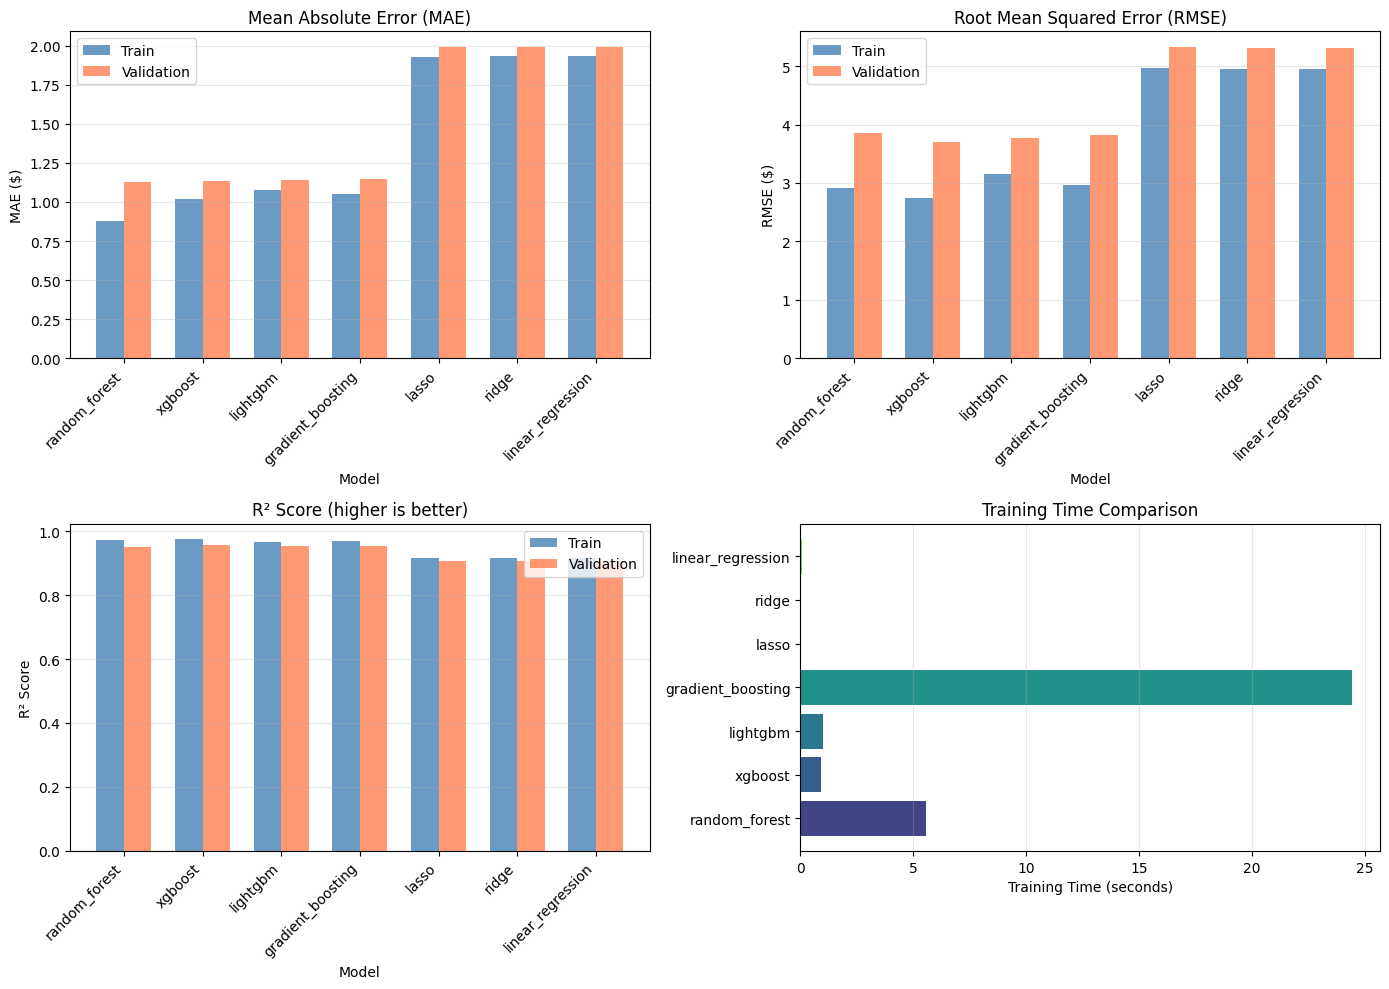


✅ Saved: ../models/model_comparison.png


In [14]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MAE Comparison
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.35
ax1.bar(x - width/2, comparison_df['Train MAE'], width, label='Train', color='steelblue', alpha=0.8)
ax1.bar(x + width/2, comparison_df['Val MAE'], width, label='Validation', color='coral', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('MAE ($)')
ax1.set_title('Mean Absolute Error (MAE)')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. RMSE Comparison
ax2 = axes[0, 1]
ax2.bar(x - width/2, comparison_df['Train RMSE'], width, label='Train', color='steelblue', alpha=0.8)
ax2.bar(x + width/2, comparison_df['Val RMSE'], width, label='Validation', color='coral', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Root Mean Squared Error (RMSE)')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. R² Comparison
ax3 = axes[1, 0]
ax3.bar(x - width/2, comparison_df['Train R²'], width, label='Train', color='steelblue', alpha=0.8)
ax3.bar(x + width/2, comparison_df['Val R²'], width, label='Validation', color='coral', alpha=0.8)
ax3.set_xlabel('Model')
ax3.set_ylabel('R² Score')
ax3.set_title('R² Score (higher is better)')
ax3.set_xticks(x)
ax3.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Training Time
ax4 = axes[1, 1]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
ax4.barh(comparison_df['Model'], comparison_df['Train Time (s)'], color=colors)
ax4.set_xlabel('Training Time (seconds)')
ax4.set_title('Training Time Comparison')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: {MODELS_DIR / 'model_comparison.png'}")


## 8. Select Best Model

In [15]:
# Find best model (lowest validation MAE)
best_result = min(results, key=lambda x: x['val_metrics']['mae'])
best_model_name = best_result['model_name']
best_model = best_result['model']

print("🏆 Best Model:")
print(f"   Name: {best_model_name}")
print(f"\n   Validation Metrics:")
print_metrics(best_result['val_metrics'], prefix="      ")


🏆 Best Model:
   Name: random_forest

   Validation Metrics:
      MAE:  $1.1288
      RMSE: $3.8475
      R²:   0.9517
      MAPE: 6.17%


## 9. Evaluate Best Model on Test Set

In [16]:
# Evaluate on test set
y_test_pred = best_model.predict(X_test)
test_metrics = evaluate_model(y_test, y_test_pred)

print(f"📊 Test Set Evaluation - {best_model_name}")
print("="*50)
print_metrics(test_metrics, prefix="   ")


📊 Test Set Evaluation - random_forest
   MAE:  $1.1140
   RMSE: $3.5899
   R²:   0.9556
   MAPE: 6.04%


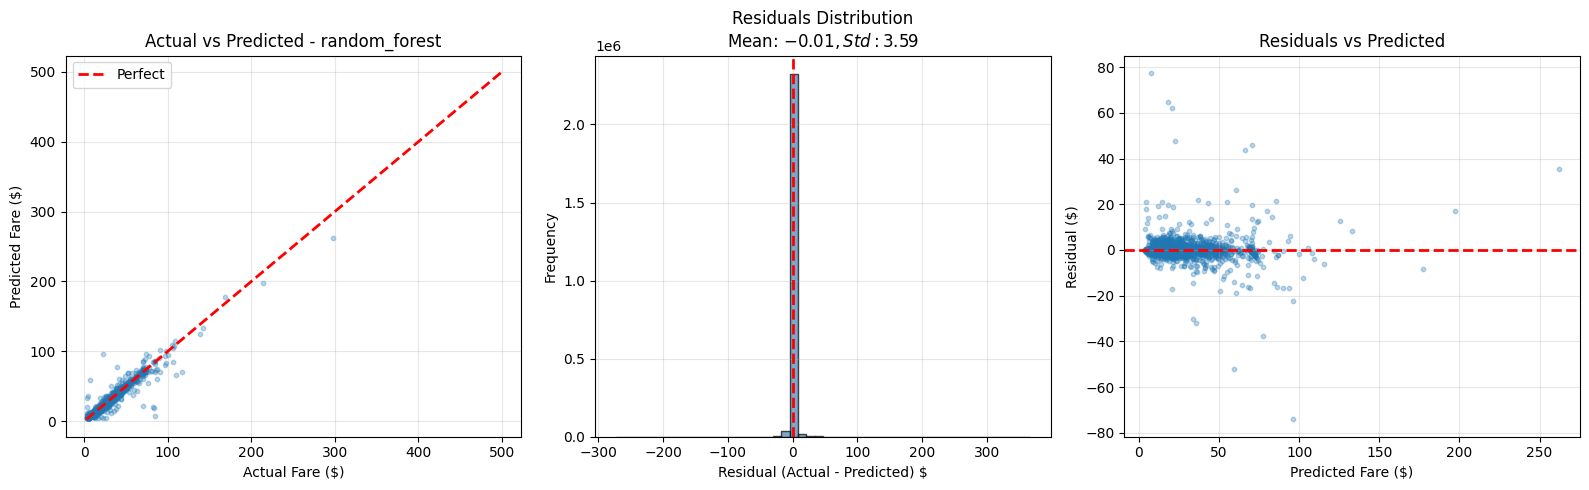


✅ Saved: ../models/best_model_evaluation.png


In [17]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Sample for visualization
sample_size = min(5000, len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
y_test_sample = y_test.iloc[sample_idx]
y_pred_sample = y_test_pred[sample_idx]

# 1. Actual vs Predicted scatter
ax1 = axes[0]
ax1.scatter(y_test_sample, y_pred_sample, alpha=0.3, s=10)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect')
ax1.set_xlabel('Actual Fare ($)')
ax1.set_ylabel('Predicted Fare ($)')
ax1.set_title(f'Actual vs Predicted - {best_model_name}')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Residuals distribution
ax2 = axes[1]
residuals = y_test - y_test_pred
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Residual (Actual - Predicted) $')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Residuals Distribution\nMean: ${residuals.mean():.2f}, Std: ${residuals.std():.2f}')
ax2.grid(alpha=0.3)

# 3. Residuals vs Predicted
ax3 = axes[2]
ax3.scatter(y_pred_sample, y_test_sample - y_pred_sample, alpha=0.3, s=10)
ax3.axhline(y=0, color='red', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Fare ($)')
ax3.set_ylabel('Residual ($)')
ax3.set_title('Residuals vs Predicted')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'best_model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: {MODELS_DIR / 'best_model_evaluation.png'}")


## 10. Feature Importance

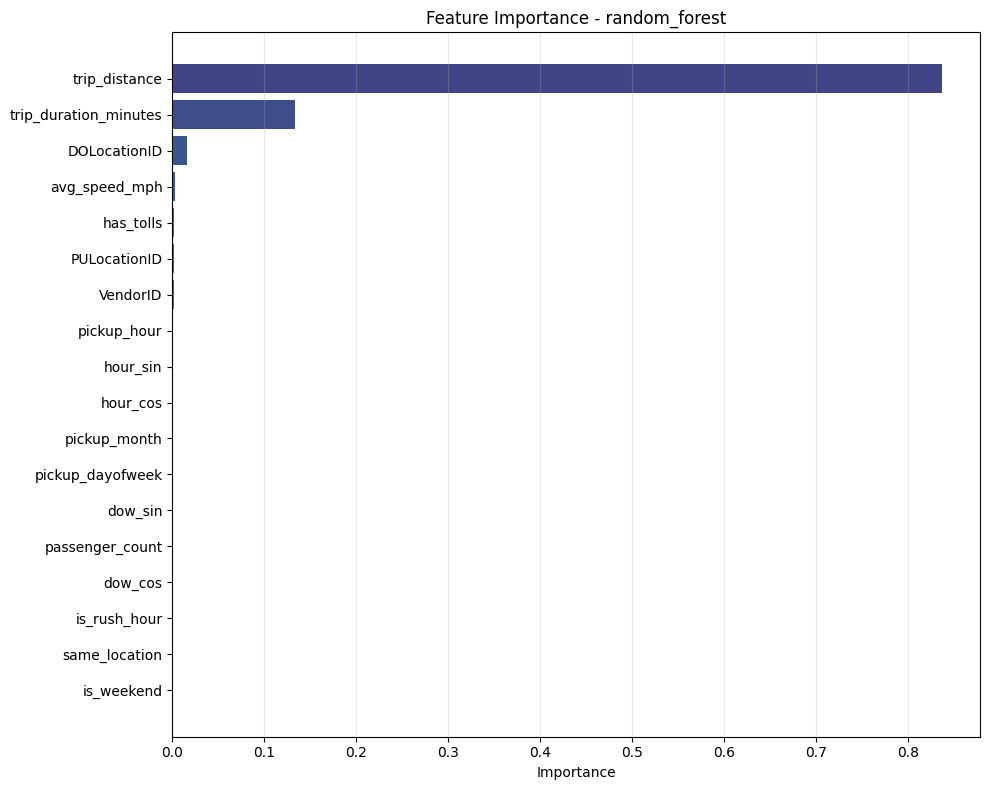


📊 Top 10 Features:
              Feature  Importance
        trip_distance    0.836594
trip_duration_minutes    0.133017
         DOLocationID    0.016064
        avg_speed_mph    0.002633
            has_tolls    0.002194
         PULocationID    0.001855
             VendorID    0.001558
          pickup_hour    0.001115
             hour_sin    0.001083
             hour_cos    0.000975


In [18]:
# Get feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': ALL_FEATURES,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_df)))
    ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance - {best_model_name}')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Top 10 Features:")
    print(importance_df.head(10).to_string(index=False))
else:
    print(f"⚠️ {best_model_name} doesn't have feature_importances_ attribute")
    
    # For linear models, use coefficients
    if hasattr(best_model, 'coef_'):
        coef_df = pd.DataFrame({
            'Feature': ALL_FEATURES,
            'Coefficient': best_model.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print("\n📊 Top 10 Features by Coefficient:")
        print(coef_df.head(10).to_string(index=False))


## 11. Save Best Model

In [19]:
# Save best model
model_path = MODELS_DIR / 'best_model.joblib'
joblib.dump(best_model, model_path)
print(f"✅ Saved best model: {model_path}")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_params': MODELS[best_model_name]['params'],
    'train_metrics': best_result['train_metrics'],
    'val_metrics': best_result['val_metrics'],
    'test_metrics': test_metrics,
    'features': ALL_FEATURES,
    'target': TARGET,
    'mlflow_run_id': best_result['run_id']
}

metadata_path = MODELS_DIR / 'model_metadata.joblib'
joblib.dump(model_metadata, metadata_path)
print(f"✅ Saved model metadata: {metadata_path}")


✅ Saved best model: ../models/best_model.joblib
✅ Saved model metadata: ../models/model_metadata.joblib


In [20]:
# Save comparison results
comparison_df.to_csv(MODELS_DIR / 'model_comparison.csv', index=False)
print(f"✅ Saved comparison: {MODELS_DIR / 'model_comparison.csv'}")


✅ Saved comparison: ../models/model_comparison.csv


In [21]:
# List saved files
print("\n📁 Saved Files:")
for f in MODELS_DIR.glob('*'):
    size_kb = f.stat().st_size / 1024
    print(f"   {f.name}: {size_kb:.1f} KB")



📁 Saved Files:
   best_model_evaluation.png: 132.9 KB
   model_comparison.csv: 1.2 KB
   model_comparison.png: 167.1 KB
   feature_importance.png: 69.9 KB
   model_metadata.joblib: 0.8 KB
   best_model.joblib: 55618.4 KB


## 12. Summary

In [22]:
print("="*70)
print("                    📋 MODELING SUMMARY")
print("="*70)

print(f"""
MODELS TRAINED: {len(MODELS)}
   - Linear Regression
   - Ridge Regression
   - Lasso Regression  
   - Random Forest
   - Gradient Boosting
   {'- XGBoost' if HAS_XGB else ''}
   {'- LightGBM' if HAS_LGB else ''}

🏆 BEST MODEL: {best_model_name}
   Validation MAE:  ${best_result['val_metrics']['mae']:.4f}
   Validation RMSE: ${best_result['val_metrics']['rmse']:.4f}
   Validation R²:   {best_result['val_metrics']['r2']:.4f}

📊 TEST SET PERFORMANCE:
   MAE:  ${test_metrics['mae']:.4f}
   RMSE: ${test_metrics['rmse']:.4f}
   R²:   {test_metrics['r2']:.4f}
   MAPE: {test_metrics['mape']:.2f}%

MLFLOW:
   ✅ All experiments logged to: {MLFLOW_TRACKING_URI}
   ✅ Experiment name: {EXPERIMENT_NAME}

SAVED FILES:
   📁 {MODELS_DIR}/
      - best_model.joblib
      - model_metadata.joblib
      - model_comparison.csv
      - model_comparison.png
      - best_model_evaluation.png
      - feature_importance.png
""")

print("="*70)
print("✅ Modeling Complete!")
print("   Next: 04_hyperparameter_tuning.ipynb (Optuna)")
print("="*70)


                    📋 MODELING SUMMARY

MODELS TRAINED: 7
   - Linear Regression
   - Ridge Regression
   - Lasso Regression  
   - Random Forest
   - Gradient Boosting
   - XGBoost
   - LightGBM

🏆 BEST MODEL: random_forest
   Validation MAE:  $1.1288
   Validation RMSE: $3.8475
   Validation R²:   0.9517

📊 TEST SET PERFORMANCE:
   MAE:  $1.1140
   RMSE: $3.5899
   R²:   0.9556
   MAPE: 6.04%

MLFLOW:
   ✅ All experiments logged to: ../mlruns
   ✅ Experiment name: nyc-taxi-fare-prediction

SAVED FILES:
   📁 ../models/
      - best_model.joblib
      - model_metadata.joblib
      - model_comparison.csv
      - model_comparison.png
      - best_model_evaluation.png
      - feature_importance.png

✅ Modeling Complete!
   Next: 04_hyperparameter_tuning.ipynb (Optuna)


---

## 🔗 Next Steps

1. **04_hyperparameter_tuning.ipynb** - Optimize best model with Optuna
2. **05_model_evaluation.ipynb** - Detailed evaluation & error analysis
3. **Deploy API** - Use saved model for inference

### MLflow UI

Untuk melihat MLflow UI, jalankan di terminal:
```bash
mlflow ui --backend-store-uri ./mlruns --port 5000
```

Lalu buka browser: http://localhost:5000